In [9]:
import sys
sys.path.append('..')

import utils, selex_dca, indep_sites
import adabmDCA
import selex_distribution, energy_models, tree, data_loading

import torch
from utils import one_hot
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

In [601]:
import importlib
importlib.reload(selex_distribution)
importlib.reload(energy_models)
importlib.reload(utils)

<module 'utils' from '/Users/scrotti/Aptamer2025py/utils.py'>

In [746]:
dtype = torch.float64
device = torch.device('cpu')

In [747]:
q = 4
L = 45

k = torch.randn(L, q, dtype=dtype, device=device)
h = torch.randn(L, q, dtype=dtype, device=device)
J = torch.randn(L, q, L, q, dtype=dtype, device=device)

tr = tree.Tree()
tr.add_node(-1)
tr.add_node(0)

selected_modes = torch.BoolTensor([[1, 0],[1, 0]])

Ns0 = energy_models.IndepSites(k)
potts = energy_models.Potts(J, h)
ps = selex_distribution.MultiModeDistribution(potts, potts, normalized=False)

def mlp(L, n_hidden=10):
    return torch.nn.Sequential(
        torch.nn.Linear(L*q, n_hidden),
        torch.nn.ReLU(),
        torch.nn.Linear(n_hidden, 1)
    ).to(dtype=dtype, device=device)

nns = [energy_models.GenericEnergyModel(mlp(L, 20)) for _ in range(2)]
ps = selex_distribution.MultiModeDistribution(*nns, normalized=False)

Nst = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes)

M = 100
x_ = torch.randint(q, (M, L))
x = one_hot(x_, num_classes=q, dtype=dtype)

In [748]:
chains = torch.zeros(M, L, q, dtype=dtype, device=device)
chains[:, :, 0] = 1

t = 1

Nst.metropolis_step_uniform_sites(chains, t)
Nst.sample_metropolis_uniform_sites(chains, t, n_sweeps=10)

In [749]:
energies = [Nst.compute_energy_up_to_round(chains, t).mean().detach().numpy()]
N = 200
for i_ in tqdm(range(N)):
    Nst.sample_metropolis_uniform_sites(chains, t, n_sweeps=1, beta=10.0)
    energies.append(Nst.compute_energy_up_to_round(chains, t).mean().detach().numpy())

  0%|          | 0/200 [00:00<?, ?it/s]

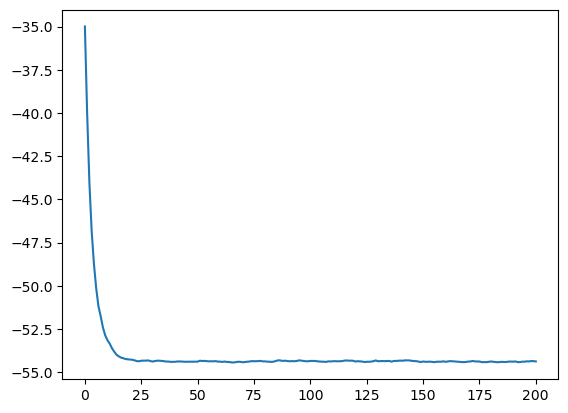

In [750]:
plt.plot(energies);

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from adabmDCA.utils import get_device, get_dtype


import sys
sys.path.append('..')
import selex_dca, utils
from utils import one_hot

In [13]:
experiment_id = "Dop8V030"
round_ids = ["ARN", "R01", "R02N"]

device = get_device("")
dtype = get_dtype("float64")

Running on CPU


In [14]:
sequences = [utils.sequences_from_file(experiment_id, round_id, device) for round_id in round_ids]

In [15]:
sequences_oh = [one_hot(seq, num_classes=q).to(dtype=dtype, device=device) for seq in sequences]

In [16]:
def init_chains(
    n_rounds: int,
    n_chains: int,
    L: int,
    q: int,
    device: torch.device,
    dtype: torch.dtype | None = None,
) -> torch.Tensor:

    if dtype is None:
        dtype = torch.float32
    chains = [torch.randint(low=0, high=q, size=(n_chains, L), device=device)
            for _ in range(n_rounds)]
    
    chains_tensor = torch.stack([one_hot(c, num_classes=q).to(dtype=dtype, device=device) for c in chains])
    
    return chains_tensor   # n_rounds, n_chains, L, q

def compute_pearson(grad_model, grad_data):
    x = torch.nn.utils.parameters_to_vector(grad_model)
    y = torch.nn.utils.parameters_to_vector(grad_data)
    return torch.corrcoef(torch.stack([x, y]))[0, 1].item()

def compute_slope(grad_model, grad_data):
    x = torch.nn.utils.parameters_to_vector(grad_model)
    y = torch.nn.utils.parameters_to_vector(grad_data)
    n = len(x)
    num = n * (x @ y) - y.sum() * x.sum()
    den = n * (x @ x) - torch.square(x.sum())
    return torch.abs(num / den)

In [404]:
fi_tuple, fij_tuple, total_reads_tuple = zip(*[utils.frequences_from_sequences_oh(s) for s in sequences_oh])
fi = torch.stack(fi_tuple)  # n_rounds, L, q
fij = torch.stack(fij_tuple)      # n_rounds, L, q, L, q
total_reads = torch.tensor(total_reads_tuple, dtype=dtype)
n_rounds, L, q = fi.size()

In [337]:
# Ri_tuple, Rij_tuple, total_reads_tuple = zip(*[utils.counts_from_sequences_oh(s) for s in sequences_oh])
# Ri = torch.stack(Ri_tuple)  # n_rounds, L, q
# Rij = torch.stack(Rij_tuple)      # n_rounds, L, q, L, q
# total_reads = torch.tensor(total_reads_tuple, dtype=dtype)
# Rtot = total_reads.sum()

In [1157]:
# normalized_total_reads = total_reads / total_reads.sum(0, keepdim=True)
# ts = torch.arange(len(normalized_total_reads))
# grad_data_cached2 = (
#     - Ri.sum(dim=0) / Rtot,
#     - (ts[:,None,None] * Ri).sum(dim=0) / Rtot
# )

In [405]:
normalized_total_reads = total_reads / total_reads.sum(0, keepdim=True)
ts = torch.arange(len(normalized_total_reads))
model.zero_grad()
for t in ts:
    en = compute_moments_data_at_round(model, sequences_oh[t], t)
    en_avg = en.mean()
    loss_t = en_avg * normalized_total_reads[t]
    loss_t.backward()

if model.round_zero.h.grad is None:
    model.round_zero.h.grad = torch.zeros_like(model.round_zero.h)
    
grad_data_cached = tuple([p.grad.detach().clone() if not p.grad is None else torch.zeros_like(h) for p in model.parameters()])
model.zero_grad()

In [732]:
# def compute_grad_model_indep(model, normalized_total_reads):
#     model.zero_grad()
#     en = torch.zeros(1)
#     for t in torch.arange(len(normalized_total_reads)):
#         pi = (model.round_zero.h.detach().clone() + t * model.selection.modes[0].h.detach().clone()).exp()
#         pi = pi / pi.sum(1, keepdim=True)
#         pi = pi.unsqueeze(0)
#         en = en + model.compute_energy_up_to_round(pi, t-1).mean() * normalized_total_reads[t]
#     en.backward()
#     gr = tuple([p.grad for p in model.parameters()])
#     return gr

In [607]:
class ConvergenceMetricsCallback:
    def __init__(self, progress_bar=True):
        self.pearson = []
        self.slope = []
        self.grad_norm = []
        self.log_likelihood = []
        self.grad_data = []
        self.grad_model = []
        self.progress_bar = progress_bar

    def before_training(self, max_epochs, *args, **kwargs):
        if self.progress_bar:
            pbar = tqdm(
                initial=0,
                total=max_epochs,
                colour="red",
                dynamic_ncols=True,
                leave=False,
                ascii="-#",
                bar_format="{desc} {percentage:.2f}%[{bar}] Epoch: {n}/{total_fmt} [{elapsed}, {rate_fmt}{postfix}]"
            )
            self.pbar = pbar

    def after_step(self, grad_model, grad_data, grad_total, log_likelihood, epochs, target_pearson, thresh_slope, *args, **kwargs):
        pearson = compute_pearson(grad_model, grad_data)
        slope = compute_slope(grad_model, grad_data)
        grad_vec = torch.nn.utils.parameters_to_vector(grad_total)
        grad_norm = torch.sqrt(torch.square(grad_vec).sum()) / len(grad_vec)
        self.pearson.append(pearson)
        self.slope.append(slope)
        self.grad_norm.append(grad_norm)
        self.log_likelihood.append(log_likelihood)
        self.grad_model.append(grad_model)
        self.grad_data.append(grad_data)

        if self.progress_bar:
            self.pbar.n = epochs
            self.pbar.set_description(f"Epoch {epochs}, Pearson = {pearson:.4e}, Gradient norm = {grad_norm:.4e}, NLL = {-log_likelihood:.4e}")
        
        c1 = pearson > target_pearson
        c2 = abs(slope - 1.) < thresh_slope

        return c1 and c2
    
    def plot(self, figsize=(10,3)):
        fig, axes = plt.subplots(1, 4, figsize=figsize)

        ax = axes[0]
        ax.plot([abs(1-p) for p in self.pearson])
        ax.set_yscale('log')
        ax.set_xlabel('iter')
        ax.set_ylabel('|1-pearson|')

        ax = axes[1]
        ax.plot([abs(1-p) for p in self.slope])
        ax.set_yscale('log')
        ax.set_xlabel('iter')
        ax.set_ylabel('|1-slope|')

        ax = axes[2]
        ax.plot(self.grad_norm)
        ax.set_yscale('log')
        ax.set_xlabel('iter')
        ax.set_ylabel('|| grad logL ||')

        ax = axes[3]
        ax.plot([-nll for nll in self.log_likelihood])
        ax.set_xlabel('iter')
        ax.set_ylabel('NLL')

        fig.tight_layout()
        
        return fig, axes
    
class PearsonCovarianceCallback:
    def __init__(self):
        self.pearson = []
        self.grad_model = []
        self.grad_data = []

    def before_training(self, *args, **kwargs):
        pass

    def after_step(self, model, grad_model, grad_data, total_reads, *args, **kwargs):
        fi = grad_data[1]
        fij = grad_data[2]
        pi = grad_model[1]
        pij = grad_model[2]
        mask = model.selection.modes[0].mask
        pij = pij * mask * 2
        fij = fij * mask * 2
        pearson, slope = selex_dca.get_correlation_two_points(fij, pij, fi, pi, total_reads)
        self.pearson.append(pearson)
        self.grad_model.append(grad_model)
        self.grad_data.append(grad_data)

        return False
    
    def plot(self, figsize=(6, 3)):
        fig, ax = plt.subplots(figsize=figsize)
        ax.plot(self.pearson)
        ax.set_xlabel('iter')
        ax.set_ylabel('Pearson $C_{ij}$')

        return fig, ax

In [842]:
import importlib
importlib.reload(selex_distribution)
importlib.reload(energy_models)
importlib.reload(utils)

<module 'utils' from '/Users/scrotti/Aptamer2025py/utils.py'>

In [843]:
from tqdm.autonotebook import tqdm

def update_chains_default():
    def update_chains(chains, t, model, n_sweeps):
        model.sample_metropolis_uniform_sites(chains, t, n_sweeps)
    return update_chains

def compute_moments_model_at_round(model, chains, t):
    # this L is not physically a likelihood, more like a computational trick
    return model.compute_energy_up_to_round(chains, t).mean()

def compute_moments_data_at_round(model, data_batch, t):
    # this L is not physically a likelihood, more like a computational trick
    return model.compute_energy_up_to_round(data_batch, t).mean()

def compute_grad_model(model, L_model, retain_graph):
    params = tuple(model.parameters())

    grad_model = torch.autograd.grad(
        outputs=L_model,
        inputs=params,
        retain_graph=retain_graph,
        create_graph=False
    )

    return grad_model

def compute_grad_data(model, L_data, retain_graph):
    params = tuple(model.parameters())

    grad_data = torch.autograd.grad(
        outputs=L_data,
        inputs=params,
        retain_graph=retain_graph,
        create_graph=False
    )

    return grad_data

def compute_total_gradient(model, grad_model, grad_data):
    grad_total = tuple(-(gm - ge) for gm, ge in zip(grad_model, grad_data))
    
    with torch.no_grad():
        for p, g in zip(model.parameters(), grad_total):
            p.grad = g

    return grad_total


def train(
    model: selex_distribution.MultiRoundDistribution,
    data_loaders,
    total_reads,
    chains: torch.Tensor,
    n_sweeps: int,
    lr: float,    
    max_epochs: int,
    target_pearson = 0.999,
    thresh_slope = 1e-2,
    l2reg: float = 0.0,
    log_weights: torch.Tensor | None = None,
    callbacks = [ConvergenceMetricsCallback()],
    update_chains = update_chains_default()
):
    n_rounds = len(data_loaders)
    assert chains.shape[0] == n_rounds
    normalized_total_reads = total_reads / total_reads.sum(0, keepdim=True)

    n_chains = chains.shape[1] 
    device=chains.device
    dtype=chains.dtype
    log_n_chains = torch.log(torch.tensor(n_chains, device=device, dtype=dtype)).item()

    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=l2reg)

    log_likelihood = - log_n_chains
    if log_weights is None:
        log_weights = torch.zeros(n_rounds, n_chains, device=device, dtype=dtype)

    epochs = 0   
    converged = (epochs > max_epochs)
    for callback in callbacks:
        callback.before_training(max_epochs=max_epochs)
        
    while not converged:
        optimizer.zero_grad()
        L_model = L_data = 0
        # log_likelihood = torch.Tensor(0)
        for t in range(n_rounds):
            # update chains
            with torch.no_grad():
                update_chains(chains, t, model, n_sweeps)
            # compute gradient
            L_m = compute_moments_model_at_round(model, chains[t].clone(), t)
            L_model = L_model + normalized_total_reads[t] * L_m
            
            # # extract batch of data from round t
            # data_batch = next(iter(data_loaders[t]))
            # L_d = compute_moments_data_at_round(model, data_batch, t)
            # L_data = L_data + normalized_total_reads[t] * L_d
            # logZt = (torch.logsumexp(log_weights[t], dim=0)).item() - log_n_chains
            # log_likelihood += normalized_total_reads[t] * (- L_d - logZt)
        
            # TODO: compute round-wise convergence metrics

        # Compute gradient
        grad_model = compute_grad_model(model, L_model, retain_graph=True)
        # grad_model = compute_grad_model_indep(model)
        grad_data = grad_data_cached
        # grad_data = compute_grad_data(model, L_data, retain_graph=False)
        grad_total = compute_total_gradient(model, grad_model, grad_data)
        # do gradient step on params
        optimizer.step()

        epochs += 1
        converged = (epochs > max_epochs)

        # callbacks
        for callback in callbacks:
            c = callback.after_step(model=model, chains=chains, total_reads=total_reads, 
                         log_likelihood = log_likelihood, epochs=epochs,
                         grad_model=grad_model, grad_data=grad_data, grad_total=grad_total,
                         target_pearson=target_pearson, thresh_slope=thresh_slope)
            converged = converged or c

In [844]:
from tqdm.autonotebook import tqdm

from adabmDCA.statmech import _update_weights_AIS
from adabmDCA.stats import _get_slope


def find_bug(
    model: selex_distribution.MultiRoundDistribution,
    data_loaders,
    sampler,
    total_reads,
    chains_old: torch.Tensor,
    chains_new: torch.Tensor,
    n_sweeps: int,
    lr: float,    
    max_epochs: int,
    target_pearson = 0.999,
    thresh_slope = 1e-2,
    l2reg: float = 0.0,
    log_weights: torch.Tensor | None = None,
    callbacks = [ConvergenceMetricsCallback()],
    progress_bar: bool = True,
):
    n_rounds = len(data_loaders)
    assert chains.shape[0] == n_rounds
    normalized_total_reads = total_reads / total_reads.sum(0, keepdim=True)

    n_chains = chains.shape[1] 
    device=chains.device
    dtype=chains.dtype
    log_n_chains = torch.log(torch.tensor(n_chains, device=device, dtype=dtype)).item()

    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=l2reg)

    params = {
        'bias_Ns0': model.round_zero.h.data.detach().clone(), 
        'bias_ps': model.selection.modes[0].h.data.detach().clone(), 
        'couplings_ps': model.selection.modes[0].J.data.detach().clone(),
        'couplings_Ns0': torch.zeros(size=(L, q, L, q), dtype=dtype, device=device)} 
    mask_ps=model.selection.modes[0].mask.data.detach().clone()
    mask_Ns0 = torch.zeros(size=(L, q, L, q), dtype=torch.bool, device=device)

    log_likelihood = - log_n_chains
    if log_weights is None:
        log_weights = torch.zeros(n_rounds, n_chains, device=device, dtype=dtype)

    epochs = 0   
    converged = (epochs > max_epochs)

    epochs = 0
    for callback in callbacks:
        callback.before_training(max_epochs=max_epochs)
        
    while not converged:
        for t in range(n_rounds):
            params_t = selex_dca.get_params_at_round(params, t)
            chains_old[t] = sampler(chains=chains_old[t], params=params_t, nsweeps=n_sweeps)\
            
        optimizer.zero_grad()
        L_model = L_data = 0
        # log_likelihood = torch.Tensor(0)
        for t in range(n_rounds):
            # update chains
            update_chains(chains_new, t, model, n_sweeps)
            # compute gradient
            L_m = compute_moments_model_at_round(model, chains_new[t].clone(), t)
            L_model = L_model + normalized_total_reads[t] * L_m
            
            # # extract batch of data from round t
            # data_batch = next(iter(data_loaders[t]))
            # L_d = compute_moments_data_at_round(model, data_batch, t)
            # L_data = L_data + normalized_total_reads[t] * L_d
            # logZt = (torch.logsumexp(log_weights[t], dim=0)).item() - log_n_chains
            # log_likelihood += normalized_total_reads[t] * (- L_d - logZt)
        
            # TODO: compute round-wise convergence metrics

        # Compute gradient
        grad_model = compute_grad_model(model, L_model, retain_graph=True)
        # grad_model = compute_grad_model_indep(model)
        grad_data = grad_data_cached
        # grad_data = compute_grad_data(model, L_data, retain_graph=False)
        grad_total = compute_total_gradient(model, grad_model, grad_data)
        # do gradient step on params
        optimizer.step()

        pi = torch.stack([adabmDCA.stats.get_freq_single_point(data=c) for c in chains_old])
        pij = torch.stack([adabmDCA.stats.get_freq_two_points(data=c) for c in chains_old])
        ts = torch.arange(len(total_reads))
        # grad_old = selex_dca.compute_gradient(fi=fi, fij=fij, pi=pi, pij=pij, total_reads=total_reads, ts=ts)
        params = selex_dca.update_params(
            fi=fi,
            fij=fij,
            pi=pi,
            pij=pij,
            total_reads=total_reads,
            params=params,
            mask_ps=mask_ps,
            mask_Ns0=mask_Ns0,
            lr=lr
        )

        pearson_cov_old, _ = selex_dca.get_correlation_two_points(fij, pij, fi, pi, total_reads, mask=mask_ps.to(torch.bool))
        pearsons_cov_old.append(pearson_cov_old)

        epochs += 1
        converged = (epochs > max_epochs)

        # callbacks
        for callback in callbacks:
            c = callback.after_step(model=model, chains=chains_new, total_reads=total_reads, 
                         log_likelihood = log_likelihood, epochs=epochs,
                         grad_model=grad_model, grad_data=grad_data, grad_total=grad_total,
                         target_pearson=target_pearson, thresh_slope=thresh_slope)
            converged = converged or c

def find_bug2(
    sampler,
    chains: torch.Tensor,
    fi: torch.Tensor,
    fij: torch.Tensor,
    total_reads: torch.Tensor,
    params,
    model,
    nsweeps: int,
    lr: float,    
    max_epochs: int,
    target_pearson: float,
    mask_ps: torch.Tensor | None = None,
    mask_Ns0: torch.Tensor | None = None,
    l2reg: float = 0.0,
    check_slope: bool = False,
    log_weights: torch.Tensor | None = None,
    history = selex_dca.init_history(),
    progress_bar: bool = True,
    callbacks = [ConvergenceMetricsCallback()],
    ):

    device = fi.device
    dtype = fi.dtype
    n_rounds, L, q = fi.shape
    n_chains = chains.size(1)

    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=l2reg)

    if mask_ps is None:
        mask_ps = torch.ones(size=(L, q, L, q), dtype=torch.bool, device=device)
        mask_ps[torch.arange(L), :, torch.arange(L), :] = 0
    if mask_Ns0 is None:
        mask_Ns0 = torch.zeros(size=(L, q, L, q), dtype=torch.bool, device=device)

    log_likelihood = 0
    W = total_reads.sum()

    # log_weights used for the online computing of the log-likelihood
    if log_weights is None:
        log_weights = torch.zeros(n_rounds, n_chains, device=device, dtype=dtype)
    for t in torch.arange(n_rounds):
        logZt = (torch.logsumexp(log_weights[t], dim=0) - torch.log(torch.tensor(n_chains, device=device, dtype=dtype))).item()
        params_round_t = selex_dca.get_params_at_round(params, t)
        log_likelihood += total_reads[t] * adabmDCA.statmech.compute_log_likelihood(fi=fi[t], fij=fij[t], params=params_round_t, logZ=logZt)
    log_likelihood /= W
            
    # Compute the single-point and two-points frequencies of the simulated data
    pi = torch.stack([adabmDCA.stats.get_freq_single_point(data=c) for c in chains])
    pij = torch.stack([adabmDCA.stats.get_freq_two_points(data=c) for c in chains])

    history["k_old"] = []
    history["k_new"] = []
    history["k_old"].append(params["bias_Ns0"].detach().clone())
    history["k_new"].append(model.round_zero.h.detach().clone())
    
    def halt_condition(epochs, pearson, slope, check_slope):
        c1 = pearson < target_pearson
        c2 = epochs < max_epochs
        if check_slope:
            c3 = abs(slope - 1.) > 0.1
        else:
            c3 = False
        return not c2 * ((not c1) * c3 + c1)

    pearson_rounds, _ = zip(*[adabmDCA.stats.get_correlation_two_points(
                                fij=fij[t], pij=pij[t], fi=fi[t], pi=pi[t]
                                )
                        for t in range(len(total_reads))])
    pearson, slope = selex_dca.get_correlation_two_points(fij, pij, fi, pi, total_reads)

    for callback in callbacks:
        callback.before_training(max_epochs=max_epochs)
    epochs = 0
    if progress_bar: 
        pbar = tqdm(
            initial=0,
            total=max_epochs,
            colour="red",
            dynamic_ncols=True,
            leave=False,
            ascii="-#",
            bar_format="{desc} {percentage:.2f}%[{bar}] Epoch: {n}/{total_fmt} [{elapsed}]"
        )
        pbar.set_description(f"Epochs: {epochs} - Pearson: {pearson:.2f}")
    
    while not halt_condition(epochs, pearson, slope, check_slope):
        
        # Store the previous parameters
        params_prev = {key: value.clone() for key, value in params.items()}
        
        # Update the parameters
        params = selex_dca.update_params(
            fi=fi,
            fij=fij,
            pi=pi,
            pij=pij,
            total_reads=total_reads,
            params=params,
            mask_ps=mask_ps,
            mask_Ns0=mask_Ns0,
            lr=lr,
            l2reg=l2reg
        )

        # Update Importance Sampling weights
        for t in range(n_rounds):
            params_prev_t = selex_dca.get_params_at_round(params_prev, t)
            params_curr_t = selex_dca.get_params_at_round(params, t)
            log_weights[t] = _update_weights_AIS(params_prev_t, params_curr_t, chains[t],  
                                                 log_weights[t])
        
        # Update the Markov chains
        with torch.no_grad():
            for t in range(n_rounds):
                # params_t = selex_dca.get_params_at_round(params, t)
                # chains[t] = sampler(chains=chains[t], params=params_t, nsweeps=nsweeps)
                update_chains_old(chains, t, model, n_sweeps=nsweeps)

        optimizer.zero_grad()
        L_model = 0
        for t in range(n_rounds):
            # update chains
            L_m = compute_moments_model_at_round(model, chains[t].clone(), t)
            L_model = L_model + normalized_total_reads[t] * L_m

        # Compute gradient
        grad_model = compute_grad_model(model, L_model, retain_graph=True)
        grad_data = grad_data_cached
        grad_total = compute_total_gradient(model, grad_model, grad_data)
        # do gradient step on params
        optimizer.step()
        
        
        # Compute the single-point and two-points frequencies of the simulated data
        pi = torch.stack([adabmDCA.stats.get_freq_single_point(data=c) for c in chains])
        pij = torch.stack([adabmDCA.stats.get_freq_two_points(data=c) for c in chains])
        pearson_rounds, _ = zip(*[adabmDCA.stats.get_correlation_two_points(
                                    fij=fij[t], pij=pij[t], fi=fi[t], pi=pi[t]
                                    )
                            for t in range(len(total_reads))])
        pearson, slope = selex_dca.get_correlation_two_points(fij, pij, fi, pi, total_reads)

        
        history["k_old"].append(params["bias_Ns0"].detach().clone())
        history["k_new"].append(model.round_zero.h.detach().clone())


        # Estimate log-likelihood
        log_likelihood = 0
        for t in torch.arange(n_rounds):
            logZt = (torch.logsumexp(log_weights[t], dim=0) - torch.log(torch.tensor(n_chains, device=device, dtype=dtype))).item()
            params_round_t = selex_dca.get_params_at_round(params, t)
            log_likelihood += total_reads[t] * adabmDCA.statmech.compute_log_likelihood(fi=fi[t], fij=fij[t], params=params_round_t, logZ=logZt)
        log_likelihood /= W
        
        epochs += 1
        if progress_bar:
            pbar.n = epochs
            pbar.set_description(f"Epochs: {epochs} - Pearson: {pearson:.2f} - LL: {log_likelihood:.2f}")
        
        history["epochs"].append(epochs)
        history["pearson"].append(pearson)
        history["slope"].append(slope)
        history["log-likelihood"].append(log_likelihood)
        history["pearson_rounds"].append(pearson_rounds)

        for callback in callbacks:
            callback.after_step(model=model, chains=chains, total_reads=total_reads, 
                log_likelihood = log_likelihood, epochs=epochs,
                grad_model=grad_model, grad_data=grad_data, grad_total=grad_total,
                target_pearson=1, thresh_slope=0)
                
    if progress_bar:
        pbar.close()
        
    return chains, params, history

In [845]:
import importlib
importlib.reload(tree)
importlib.reload(selex_distribution)
importlib.reload(energy_models)

<module 'energy_models' from '/Users/scrotti/Aptamer2025py/energy_models.py'>

In [846]:
k = torch.zeros(L, q, dtype=dtype, device=device)
k = torch.log(fi[0])
h = torch.zeros(L, q, dtype=dtype, device=device)
# h = torch.log(fi[-1]) - torch.log(fi[0])
J = torch.zeros(L, q, L, q, dtype=dtype, device=device)

tr = tree.Tree()
tr.add_node(-1)
tr.add_node(0)

selected_modes = torch.BoolTensor([[1],[1]])

Ns0 = energy_models.IndepSites(k)
potts = energy_models.Potts(J, h)
indep = energy_models.IndepSites(h)
ps = selex_distribution.MultiModeDistribution(potts, normalized=False)
model = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes)

In [847]:
# normalized_total_reads = total_reads / total_reads.sum(0, keepdim=True)
# ts = torch.arange(len(normalized_total_reads))
# model.zero_grad()
# for t in ts:
#     en = compute_moments_data_at_round(model, sequences_oh[t], t)
#     en_avg = en.mean()
#     loss_t = en_avg * normalized_total_reads[t]
#     loss_t.backward()

# if model.round_zero.h.grad is None:
#     model.round_zero.h.grad = torch.zeros_like(model.round_zero.h)
    
# grad_data_cached = tuple([p.grad if not p.grad is None else torch.zeros_like(h) for p in model.parameters()])
# model.zero_grad()

In [848]:
# normalized_total_reads = total_reads / total_reads.sum(0, keepdim=True)
# ts = torch.arange(len(normalized_total_reads))
# grad_data_cached2 = (
#     - (normalized_total_reads[:,None,None] * fi).sum(dim=0),
#     - ((ts * normalized_total_reads)[:,None,None] * fi).sum(dim=0),
#     - ((ts * normalized_total_reads)[:,None,None,None,None] * fij / 2).sum(dim=0),
# )

In [849]:
n_chains = 10**3

datasets = [data_loading.SelexRoundDataset(seq_oh) for seq_oh in sequences_oh]
n_rounds = len(datasets) 
chains = init_chains(n_rounds, n_chains, L, q, device, dtype)
log_weights = torch.zeros(n_rounds, n_chains, device=device, dtype=dtype)

In [850]:
# batch_size = 10**6
# data_loaders = [torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True) for ds in datasets]

## TODO
A ogni classe assegnare dei metodi calcola media empirica, calcola media modello, che defaultano a usare le batch/chains ma altrimenti fanno una cosa piu efficiente
Metropolis efficiente per modelli fattorizzati

Trovare buon batch size calcolando l'energia con diversi batch e guardando deviazione

Aggiornare weights AIS

In [851]:
callbacks = [ConvergenceMetricsCallback(), PearsonCovarianceCallback()]

In [852]:
self = model
t = 1
x = chains[:,:1000,:,:]
def foo():
    with torch.no_grad():
        update_chains_new(x, t, model, n_sweeps)

# %lprun -f selex_distribution.MultiRoundDistribution.compute_energy_up_to_round foo()
# %lprun -f energy_models.Potts.compute_energy foo()
%lprun -f selex_distribution.MultiModeDistribution.compute_energy foo()

Timer unit: 1e-09 s

Total time: 8.39283 s
File: /Users/scrotti/Aptamer2025py/selex_distribution.py
Function: MultiModeDistribution.compute_energy at line 25

Line #      Hits         Time  Per Hit   % Time  Line Contents
    25                                               def compute_energy(
    26                                                       self,
    27                                                       x: torch.Tensor, # batch_size * L * q
    28                                                       selected: torch.BoolTensor, # n_rounds * n_modes
    29                                               ):
    30     20000 7846241000.0 392312.0     93.5          minus_en_ = tuple(mode.compute_energy(x) for mode in self.modes)
    31     20000   70754000.0   3537.7      0.8          minus_en = torch.stack(minus_en_, dim=1)
    32     20000    6950000.0    347.5      0.1          if self.normalized == True:
    33                                                       minus_e

In [ ]:
n_sweeps = 10
lr = 0.01
target_pearson = 1
max_epochs = 20
update_chains_new = update_chains_default()

train(model, data_loaders, total_reads, chains, n_sweeps, lr, max_epochs, target_pearson,
      callbacks=callbacks, update_chains = update_chains_new)

 0.00%[                               ] Epoch: 0/20 [00:00, ?it/s]

(<Figure size 1000x300 with 4 Axes>,
 array([<Axes: xlabel='iter', ylabel='|1-pearson|'>,
        <Axes: xlabel='iter', ylabel='|1-slope|'>,
        <Axes: xlabel='iter', ylabel='|| grad logL ||'>,
        <Axes: xlabel='iter', ylabel='NLL'>], dtype=object))

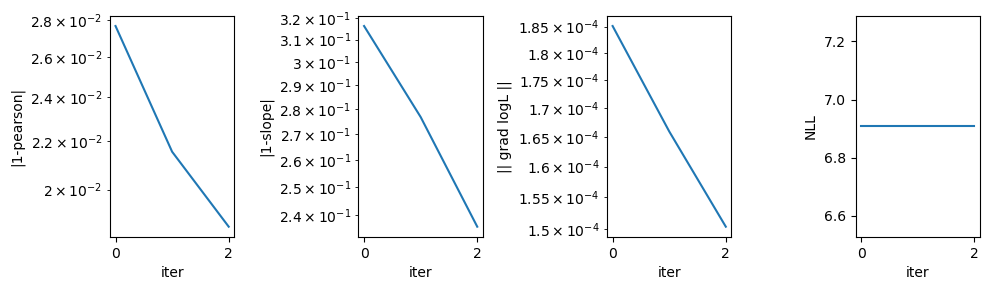

In [813]:
callbacks[0].plot()

(<Figure size 600x300 with 1 Axes>,
 <Axes: xlabel='iter', ylabel='Pearson $C_{ij}$'>)

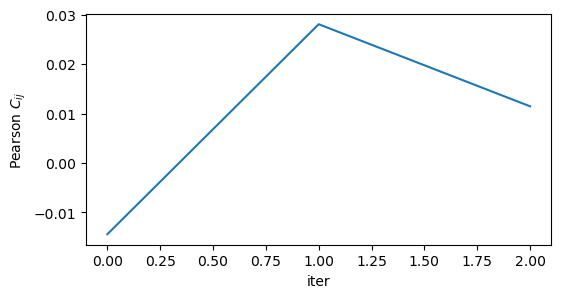

In [814]:
callbacks[1].plot()

In [744]:
from adabmDCA.sampling import get_sampler

def update_chains_oldsampler():
    sampler_alg = "gibbs"
    sampler = torch.jit.script(get_sampler(sampler_alg))
    def update_chains(chains, t, model, n_sweeps):
        h = model.round_zero.h + t * model.selection.modes[0].h
        J = t * model.selection.modes[0].J
        params_t = {"bias": h, "coupling_matrix": J}
        chains[t] = sampler(chains=chains[t], params=params_t, nsweeps=n_sweeps)
    return update_chains

update_chains_old = update_chains_oldsampler()

In [597]:
params = selex_dca.init_parameters(fi)
history = selex_dca.init_history()
callbacks = [PearsonCovarianceCallback()]

In [555]:
n_sweeps = 10
lr = 0.01
target_pearson = 0.9999
max_epochs = 10

chains, params, history = find_bug2(sampler, chains, fi, fij, total_reads, params, model, nsweeps=n_sweeps, lr=lr, max_epochs=max_epochs, 
          target_pearson=target_pearson, callbacks=callbacks, progress_bar=True, history=history)

 0.00%[                                                    ] Epoch: 0/10 [00:00]

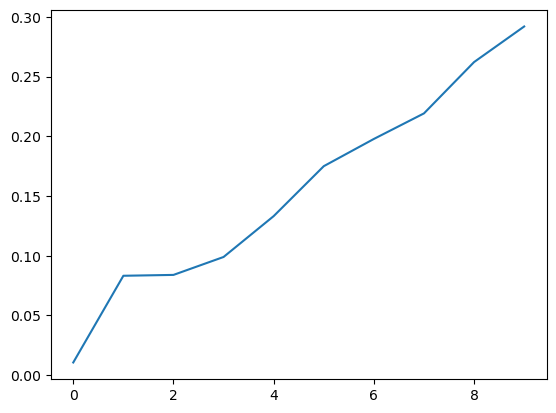

In [556]:
plt.plot(history["pearson"])

(<Figure size 600x300 with 1 Axes>,
 <Axes: xlabel='iter', ylabel='Pearson $C_{ij}$'>)

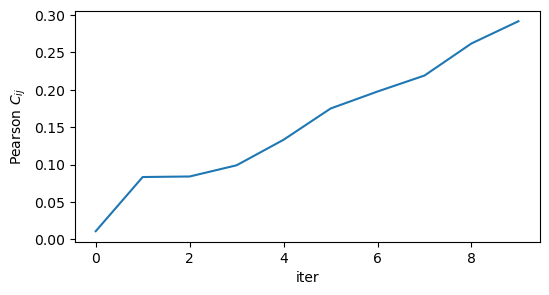

In [557]:
callbacks[0].plot()

In [586]:
# %load_ext line_profiler

# max_epochs = 10
# %lprun -f train(model, data_loaders, total_reads, chains, n_sweeps, lr, max_epochs, target_pearson, log_weights=log_weights, callbacks=callbacks, progress_bar=True)

In [210]:
from adabmDCA.sampling import get_sampler

pearsons_cov_old = []
chains_new = chains.clone()
chains_old = chains.clone()
sampler = get_sampler('metropolis')

In [310]:
n_sweeps = 10
lr = 0.01
target_pearson = 0.9999
max_epochs = 500

find_bug(model, data_loaders, sampler, total_reads, chains_old, chains_new, n_sweeps, lr, max_epochs, target_pearson,
      log_weights=log_weights, callbacks=callbacks, progress_bar=True)

KeyboardInterrupt: 

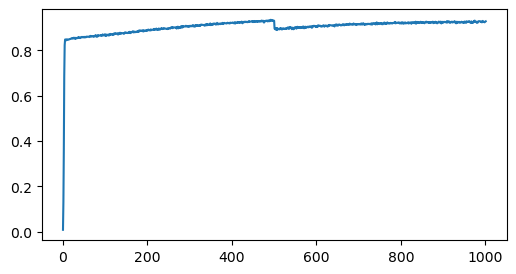

In [217]:
fig, ax = plt.subplots(figsize=(6,3))
ax.plot(pearsons_cov_old)

(<Figure size 600x300 with 1 Axes>,
 <Axes: xlabel='iter', ylabel='Pearson $C_{ij}$'>)

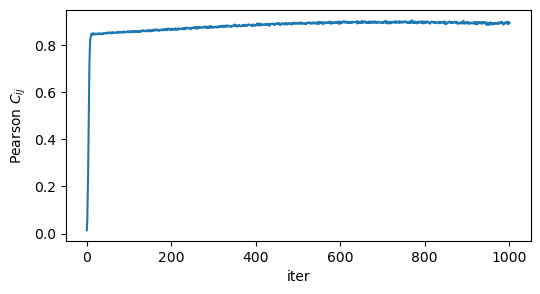

In [218]:
callbacks[1].plot()

In [ ]:
from adabmDCA.sampling import get_sampler

def update_chains_oldsampler():
    sampler_alg = "gibbs"
    sampler = torch.jit.script(get_sampler(sampler_alg))
    def update_chains(chains, t, model, n_sweeps):
        h = model.round_zero.h + t * model.selection.modes[0].h
        J = t * model.selection.modes[0].J
        params_t = {"bias": h, "coupling_matrix": J}
        chains[t] = sampler(chains=chains[t], params=params_t, nsweeps=n_sweeps)
    return update_chains

In [97]:
n_sweeps = 10
lr = 0.01
target_pearson = 0.9999
max_epochs = 50

train(model, data_loaders, total_reads, chains, n_sweeps, lr, max_epochs, target_pearson,
      log_weights=log_weights, callbacks=callbacks, progress_bar=True)

 0.00%[                                 ] Epoch: 0/50 [00:00, ?it/s]

KeyboardInterrupt: 

In [ ]:
train(model, data_loaders, total_reads, chains, n_sweeps, lr, max_epochs,
      log_weights=log_weights, callbacks=callbacks, progress_bar=True,
      update_chains=update_chains_oldsampler())

In [130]:
epoch = -1
grad_model = callbacks[0].grad_model[epoch]
grad_data = callbacks[0].grad_data[epoch]
fi = grad_data[1]
fij = grad_data[2]
pi = grad_model[1]
pij = grad_model[2]
mask = model.selection.modes[0].mask
pij = pij * mask * 2
fij = fij * mask * 2
fij_extract, pij_extract = selex_dca.extract_Cij_from_freq(fij, pij, fi, pi, total_reads)

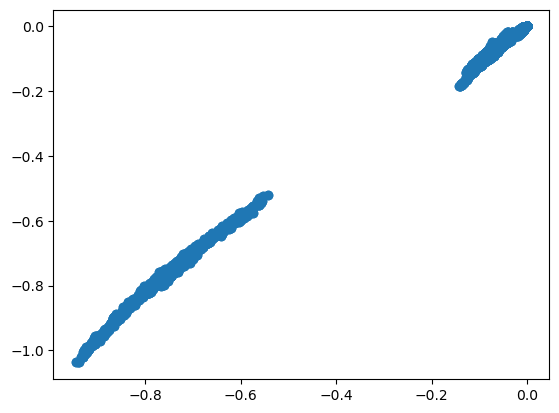

In [131]:
plt.scatter(pij, fij)

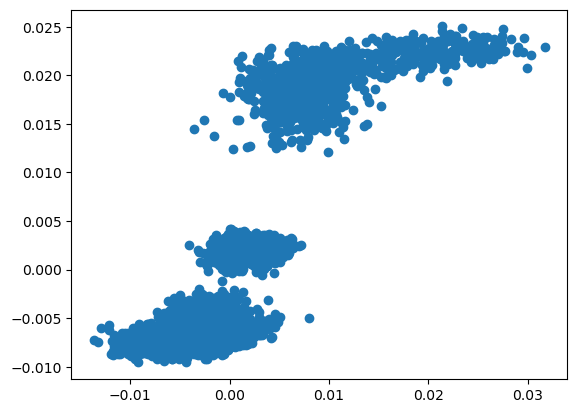

In [132]:
plt.scatter(fij_extract, pij_extract)

(<Figure size 600x300 with 1 Axes>,
 <Axes: xlabel='iter', ylabel='Pearson $C_{ij}$'>)

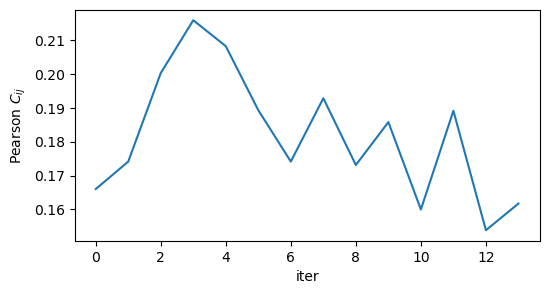

In [98]:
callbacks[1].plot()

(<Figure size 1000x300 with 4 Axes>,
 array([<Axes: xlabel='iter', ylabel='|1-pearson|'>,
        <Axes: xlabel='iter', ylabel='|1-slope|'>,
        <Axes: xlabel='iter', ylabel='|| grad logL ||'>,
        <Axes: xlabel='iter', ylabel='NLL'>], dtype=object))

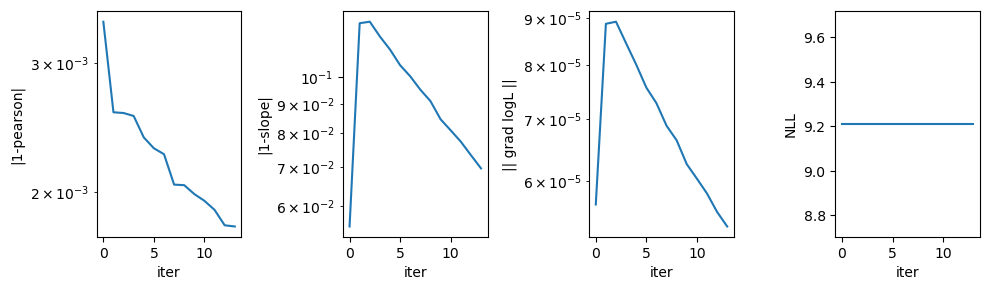

In [99]:
callbacks[0].plot()

In [920]:
history_indep = indep_sites.init_history()
params=indep_sites.init_parameters(fi)

params, history_indep = indep_sites.train(
    fi = fi,
    total_reads = total_reads,
    params = params,
    lr = 1e-2,    
    max_epochs = 5*10**4,
    target_error = 1e-12,
    history = history_indep,
    progress_bar = False
)

KeyboardInterrupt: 

In [807]:
params = utils.set_zerosum_gauge(params)
h_indep = params['bias_ps']
k_indep = params['bias_Ns0']

In [815]:
potts = model.selection.modes[0].set_zerosum_gauge()
ns0 = model.round_zero.set_zerosum_gauge()
h_model = potts.h.detach().numpy()
k_model = ns0.h.detach().numpy()

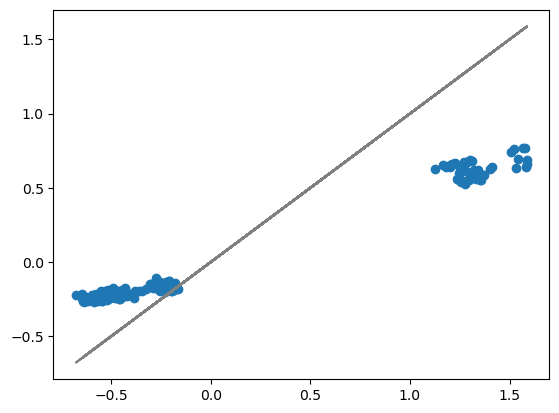

In [809]:
plt.scatter(k_indep, k_model)
plt.plot(k_indep, k_indep, color='gray');

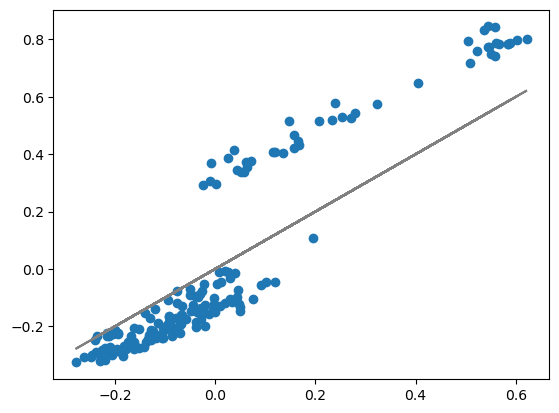

In [819]:
plt.scatter(h_indep, h_model)
plt.plot(h_indep, h_indep, color='gray');

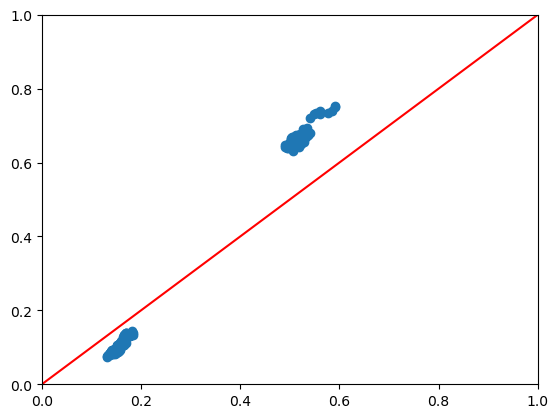

In [820]:
pi = history["pi"][-1]
x = pi.view(-1)
y = fi[0].view(-1)
plt.scatter(x, y)
plt.xlim((0,1))
plt.ylim((0,1))
plt.plot((0,1), (0,1), color='red')

<IPython.core.display.Latex object>

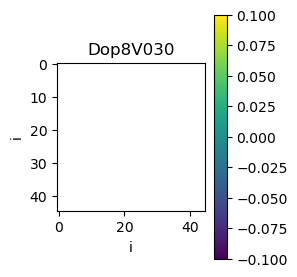

In [58]:
from IPython.display import display, Latex

potts_zerosum = potts.set_zerosum_gauge()

potts_zerosum = potts.set_zerosum_gauge()
pl, ax = plt.subplots(figsize=(3,3))
F = selex_dca.get_contact_map(potts_zerosum.J.detach())
im = ax.imshow(F)
ax.set_xlabel("i"); ax.set_ylabel("i")
ax.set_title(experiment_id)
plt.colorbar(im)
plt.tight_layout()
display(Latex("$F_{ij}=\\sqrt {\\sum_{ab}(J_{ij}^{ab})^2}$"))